In [16]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

import numpy as np

from dcgan.components.generator import Generator
from dcgan.components.discriminator import Discriminator

In [49]:
class EWC:
    def __init__(self):
        pass


def fisher(model, likelihood, nsample=1):
    """
    Funny ref link:
    https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    grads = autograd.grad(likelihood, model.parameters())
    fs = []
    for g in grads:
        fs.append((g**2).sum()/nsample) 

    param_names = [name for name, _ in model.named_parameters()]
    fs_dict = {n: f.item() for n, f in zip(param_names, fs)}

    return fs, fs_dict


def calc_ewc(model, model_0, fishers, weight):
    ewc = 0

    old_params = {n: p for n, p in model_0.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    for i, name in enumerate(fishers):
        _ewc = fishers[name]*(params[name] - old_params[name])**2
        ewc += _ewc.sum()

    return weight*ewc


def loss_adapt(l_adv, current_model, old_model, fishers, fweight):
    print(">>> l_adv", l_adv)
    ewc = calc_ewc(current_model, old_model, fishers, fweight)
    return l_adv + ewc

In [23]:
gen_model = Generator()
dis_model = Discriminator()

gen_model.load_state_dict(torch.load('models/epoch145_gen.pth'))
dis_model.load_state_dict(torch.load('models/epoch145_dis.pth'))

<All keys matched successfully>

In [28]:
batch_size = 256
latent_size = 512
regWeight = 10
criterion = nn.BCELoss()

noise = torch.randn(batch_size, latent_size)
output = dis_model(gen_model(noise)).view(-1)
real_label = torch.full((batch_size, ), 1, dtype=torch.float)
l_adv = criterion(output, real_label)

fs, fs_dict = fisher(gen_model, l_adv, nsample=batch_size)

print(fs_dict)

{'main.0.weight': 0.019720986485481262, 'main.3.weight': 0.0007198548992164433, 'main.4.weight': 0.00549681019037962, 'main.4.bias': 0.010634327307343483, 'main.6.weight': 0.02362094819545746, 'main.7.weight': 0.018067026510834694, 'main.7.bias': 0.010311858728528023, 'main.9.weight': 0.13327598571777344, 'main.10.weight': 0.018103817477822304, 'main.10.bias': 0.0183103084564209, 'main.12.weight': 0.17292261123657227, 'main.13.weight': 0.057869523763656616, 'main.13.bias': 0.021720577031373978, 'main.15.weight': 0.11394371092319489, 'main.16.weight': 0.06892213970422745, 'main.16.bias': 0.03930448368191719, 'main.18.weight': 1.8881585597991943, 'main.19.weight': 0.03383442386984825, 'main.19.bias': 0.041924018412828445, 'main.21.weight': 13.963349342346191}


In [50]:
generator_new = deepcopy(gen_model)
loss_adapt(
    l_adv, generator_new, gen_model,
    fishers=fs_dict, fweight=1
)

>>> l_adv tensor(5.4664, grad_fn=<BinaryCrossEntropyBackward0>)


tensor(5.4664, grad_fn=<AddBackward0>)

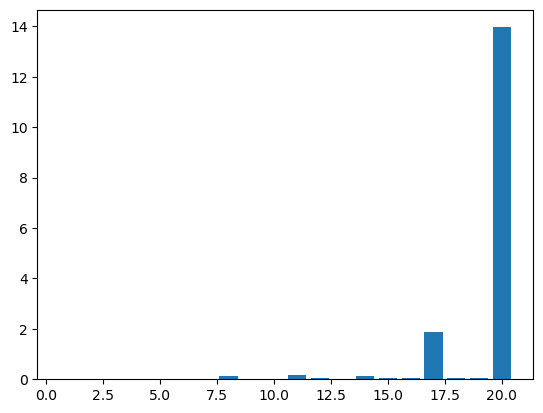

In [29]:
import matplotlib.pyplot as plt

fisher_vals = [fs_dict[n] for n in fs_dict]

plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.show()